In [1]:
# import packages
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.integrate as integrate
import numpy as np
from ar1_approx import *

In [2]:
alpha_k = 0.297
alpha_l = 0.650
delta = 0.154
psi = 1.080
w = 0.700
r = 0.040
sigma_z = 0.213
mu = 0.000
rho = 0.7605
sizez = 9
betafirm = 1 / (1 + r)
VFtol = 1e-6
VFmaxiter = 3000

In [3]:
z_grid, pi = addacooper(sizez, mu, rho, sigma_z)
z_grid = np.exp(z_grid)

In [4]:
dens = 2
# put in bounds here for the capital stock space
kstar = (((alpha_k / (1 / betafirm - 1 + delta))**(1 - alpha_l)) * ((alpha_l / w) ** alpha_l)) ** (1 - alpha_k - alpha_l)
#kstar = kstar = ((((1 / betafirm - 1 + delta) * ((w / alpha_l) **
#                                         (alpha_l / (1 - alpha_l)))) /
#         (alpha_k)) **
#         ((1 - alpha_l) / (alpha_k + alpha_l - 1)))
kbar = 2*kstar
lb_k = 0.001
ub_k = kbar
krat = np.log(lb_k / ub_k)
numb = np.ceil(krat / np.log(1 - delta))
K = np.zeros(int(numb * dens))
# we'll create in a way where we pin down the upper bound - since
# the distance will be small near the lower bound, we'll miss that by little
for j in range(int(numb * dens)):
    K[j] = ub_k * (1 - delta) ** (j / dens)
k_grid = K[::-1]
sizek = k_grid.shape[0]

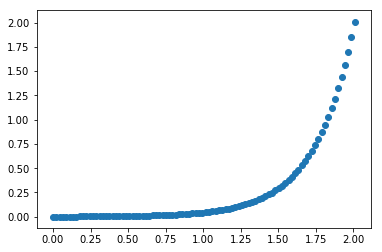

In [5]:
k_linear = np.linspace(lb_k, ub_k, num=sizek)
plt.scatter(k_linear, k_grid)
plt.show()

In [6]:
op_grid = np.empty((sizek, sizez))

for i in range(sizez):
    op_grid[:, i] = (1 - alpha_l) * ((alpha_l / w) ** (alpha_l / (1 - alpha_l))) * (z_grid[i] ** (1 / (1 - alpha_l))) * (k_grid ** (alpha_k / (1 - alpha_l)))

# firm cash flow, e
e_grid = np.zeros((sizek, sizek, sizez))
for i in range(sizek):
    for j in range(sizek):
        for k in range(sizez):
            e_grid[i, j, k] = (op_grid[i, k] - k_grid[j] + ((1 - delta) * k_grid[i]) -
                       ((psi / 2) * ((k_grid[j] - ((1 - delta) * k_grid[i])) ** 2)
                        / k_grid[i]))

In [7]:
V = np.zeros((sizek, sizez))  # initial guess at value function
Vmat = np.zeros((sizek, sizek, sizez))  # initialize Vmat matrix
VFiter = 1
VFdist = 7.0

In [8]:
while VFdist > VFtol and VFiter < VFmaxiter:
    TV = V.copy()
    for i in range(sizek):  # loop over k
        for j in range(sizek):  # loop over k'
            for k in range(sizez):  # loop over z
                Vmat[i, j, k] = e_grid[i, j, k] + betafirm * pi[k, :]@V[j, :]
    V = Vmat.max(axis=1)  # apply max operator to Vmat
    PF_indices = np.argmax(Vmat, axis=1)  # find the index of the optimal k'
    VFdist = (np.absolute(V - TV)).max()  # check distance between value
    # function for this iteration and value function from past iteration
    VFiter += 1

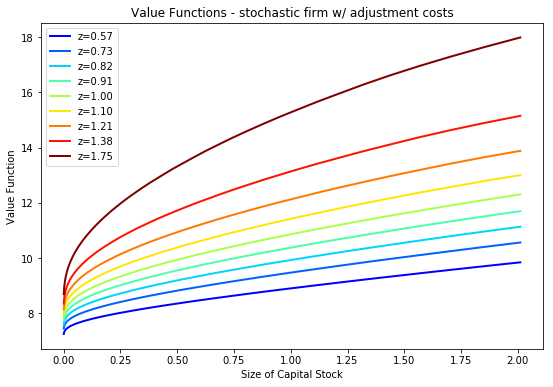

In [9]:
plt.subplots(figsize=(9, 6))
for k in range(sizez):
    lb = 'z='+format(z_grid[k],'.2f')
    plt.plot(k_grid, V[:,k], color=plt.cm.jet((k+1)/sizez),lw=2,label=lb)
plt.xlabel('Size of Capital Stock')
plt.ylabel('Value Function')
plt.title('Value Functions - stochastic firm w/ adjustment costs')
plt.legend(loc='best')
plt.show()

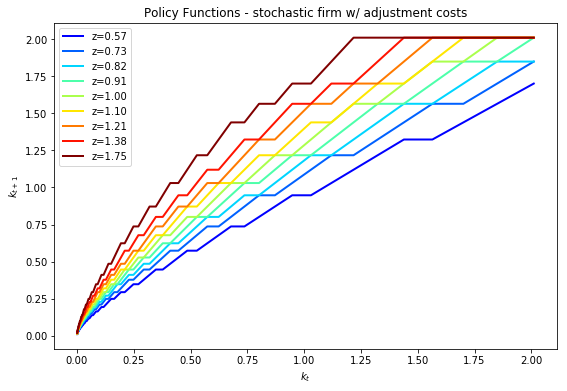

In [10]:
PF = np.empty((sizek, sizez))

for i in range(sizek):
    for j in range(sizez):
        PF[i, j] = k_grid[PF_indices[i, j]]

plt.subplots(figsize=(9, 6))
for k in range(sizez):
    lb = 'z='+format(z_grid[k],'.2f')
    plt.plot(k_grid, PF[:,k], color=plt.cm.jet((k+1)/sizez),lw=2,label=lb)
plt.xlabel(r'$k_t$')
plt.ylabel(r'$k_{t + 1}$')
plt.title('Policy Functions - stochastic firm w/ adjustment costs')
plt.legend(loc='best')
plt.show()

In [11]:
V = np.zeros((sizek, sizez))  # initial guess at value function
Vmat1 = np.zeros((sizek, sizek, sizez))  # initialize the first Vmat matrix
Vmat2 = np.zeros((sizek, sizek, sizez))  # initialize the second Vmat matrix
VFiter = 1
VFdist = 7.0

In [12]:
while VFdist > VFtol and VFiter < VFmaxiter:
    TV = V.copy()
    for i in range(sizek):  # loop over k
        for j in range(sizek):  # loop over k'
            for k in range(sizez):  # loop over z
                Vmat1[i, j, k] = op_grid[i, k] - k_grid[j] + ((1 - delta) * k_grid[i]) - psi * k_grid[i] + betafirm * pi[k, :]@V[j, :]
                Vmat2[i, j, k] = op_grid[i, k] + betafirm * (1 - delta) * pi[k, :]@V[i, :]
    PF1_indices = np.argmax(Vmat1, axis=1)
    PF2_indices = np.argmax(Vmat2, axis=1)
    PF_indices = np.empty((sizek, sizez))
    for i in range(sizek):
        for k in range(sizez):
            val1 = Vmat1[i, int(PF1_indices[i, k]), k]
            val2 = Vmat2[i, int(PF2_indices[i, k]), k]
            if val1 > val2:
                PF_indices[i, k] = PF1_indices[i, k]
                V[i, k] = val1
            else:
                PF_indices[i, k] = PF2_indices[i, k]
                V[i, k] = val2
    VFdist = (np.absolute(V - TV)).max()  # check distance between value
    # function for this iteration and value function from past iteration
    VFiter += 1

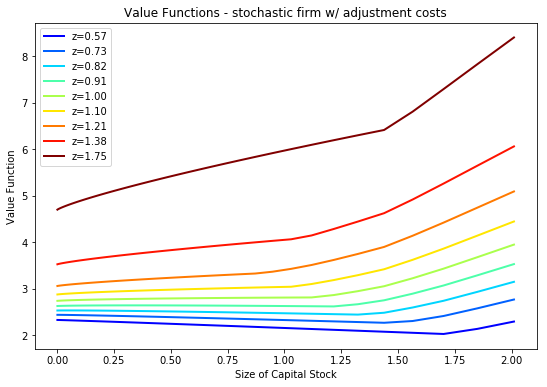

In [14]:
plt.subplots(figsize=(9, 6))
for k in range(sizez):
    lb = 'z='+format(z_grid[k],'.2f')
    plt.plot(k_grid, V[:,k], color=plt.cm.jet((k+1)/sizez),lw=2,label=lb)
plt.xlabel('Size of Capital Stock')
plt.ylabel('Value Function')
plt.title('Value Functions - stochastic firm w/ adjustment costs')
plt.legend(loc='best')
plt.show()

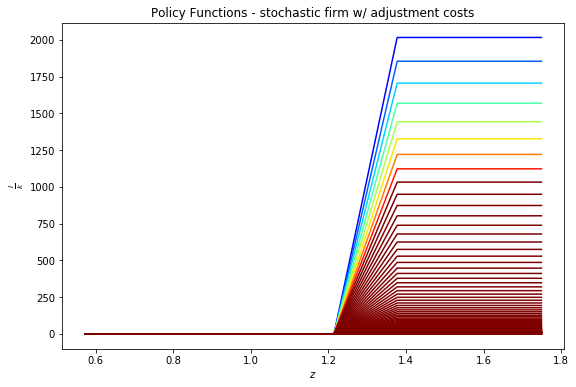

In [15]:
PF = np.empty((sizek, sizez))

for i in range(sizek):
    for j in range(sizez):
        PF[i, j] = k_grid[int(PF_indices[i, j])]

plt.subplots(figsize=(9, 6))
for i in range(sizek):
    plt.plot(z_grid, (PF[i,:] - (1 - delta) * k_grid[i]) / k_grid[i], color=plt.cm.jet((i+1)/sizez))
plt.xlabel(r'$z$')
plt.ylabel(r'$\frac{I}{k}$')
plt.title('Policy Functions - stochastic firm w/ adjustment costs')
plt.show()

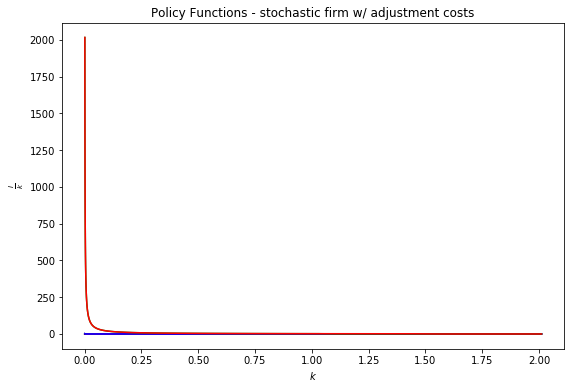

In [17]:
plt.subplots(figsize=(9, 6))
clist = ['k', 'k', 'k', 'k', 'k', 'm', 'b', 'g', 'r']
for k in range(sizez):
    plt.plot(k_grid, (PF[:,k] - (1 - delta) * k_grid) / k_grid, c=clist[k])
plt.xlabel(r'$k$')
plt.ylabel(r'$\frac{I}{k}$')
plt.title('Policy Functions - stochastic firm w/ adjustment costs')
plt.show()